In [2]:

import numpy as np
import astropy.units as u
from astropy.io import fits
import time
from importlib import reload
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3



In [19]:
reload(scoobi)
xc, yc = (4263, 2920)
npsf = 500
scoobi.set_zwo_roi(xc, yc, npsf)

Succesfully initialized testbed interface.


In [57]:
reload(scoobi)
tbi = scoobi.SCOOBI(cam_channel='scicam', dm_channel='dm00disp05')
tbi.zero_dm()

Succesfully initialized testbed interface.


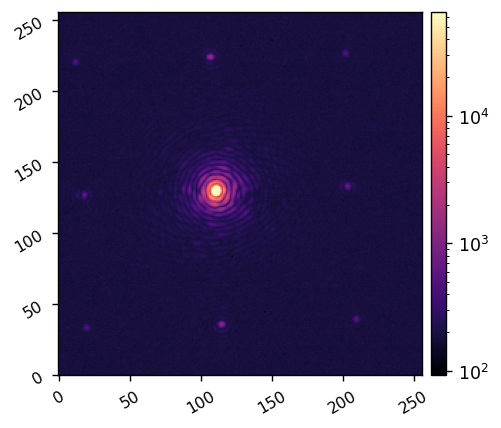

In [38]:
im = tbi.snap()
imshow1(im, lognorm=True)

# Do the normalization

In [33]:
scoobi.move_psf(50, 0)

3.19999999192078e-05

In [39]:
reload(scoobi)
scoobi.set_zwo_exp_time(0.00001)

Succesfully initialized testbed interface.


In [36]:
reload(scoobi)
scoobi.set_fib_atten(10)

Succesfully initialized testbed interface.


KeyError: 'No device fiberatten represented within these properties'

30606.4


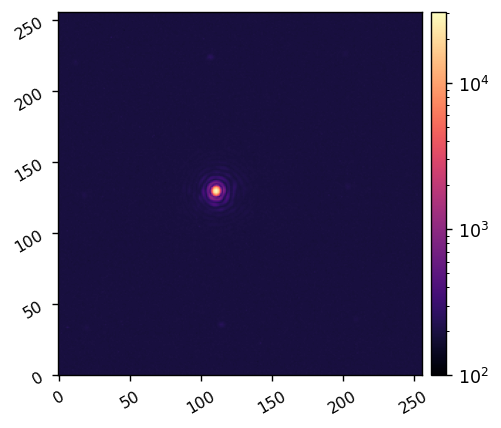

In [44]:
tbi.Nframes = 10
ref_psf = tbi.snap()
print(xp.max(im))
imshow1(im, lognorm=True, vmin=1e2)

In [53]:
reload(scoobi)
scoobi.get_zwo_exp_time()

Succesfully initialized testbed interface.


3.19999999192078e-05

In [89]:
10**((5 - 10)/10) 

0.31622776601683794

In [99]:
reload(scoobi)
tbi = scoobi.SCOOBI(cam_channel='scicam', dm_channel='dm00disp05')
tbi.zero_dm()

Succesfully initialized testbed interface.


In [100]:
tbi.Imax_ref = xp.max(ref_psf)
tbi.att_ref = 10
tbi.texp_ref = 3.2e-5

In [103]:
scoobi.set_zwo_exp_time(0.005)

In [81]:
scoobi.move_psf(2, 0)

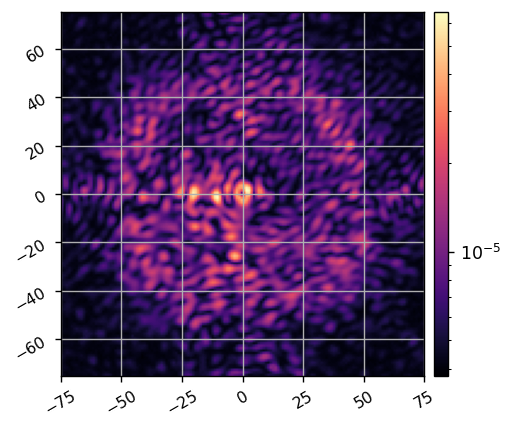

In [104]:
tbi.Nframes = 10
tbi.npsf = 150
tbi.x_shift = -3
tbi.y_shift = 0 

tbi.texp = scoobi.get_zwo_exp_time()
tbi.att = 0
tbi.return_ni = True

coro_im = tbi.snap()
imshow1(coro_im, lognorm=True, pxscl=1, grid=True)

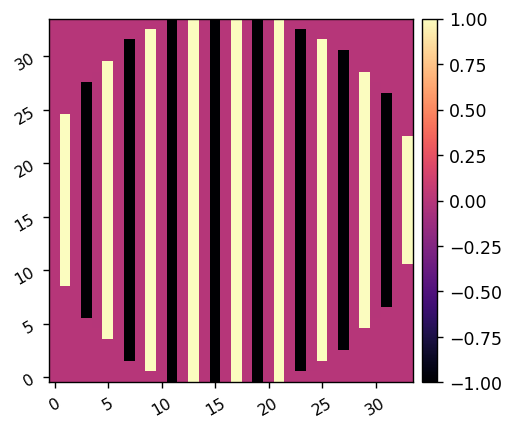

In [105]:
def create_sin_command(x_cpa=10, y_cpa=10, Nact=34):
    # cpa = cycles per aperture
    # max cpa must be Nact/2
    if x_cpa>Nact/2 or y_cpa>Nact/2:
        raise ValueError('The cycles per aperture is too high for the specified number of actuators.')
    y,x = xp.indices((Nact, Nact)) - Nact//2
    sin_command = xp.cos(2*np.pi*(x_cpa*x + y_cpa*y)/Nact)
    return sin_command

sin_command = create_sin_command(x_cpa=8.5, y_cpa=0) * xp.array(tbi.dm_mask)
imshow1(sin_command)


In [14]:
tbi.zero_dm()

In [106]:
tbi.set_dm(5e-9 * sin_command)

In [107]:
sin_im = tbi.snap()

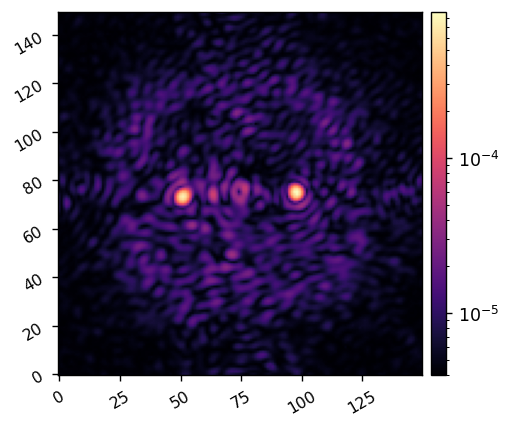

In [108]:
imshow1(sin_im, lognorm=True)

In [110]:
import skimage

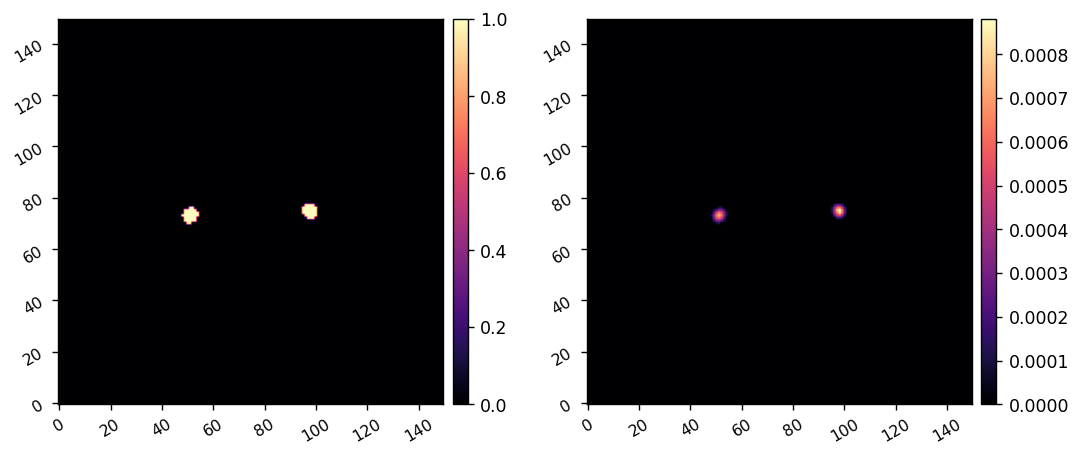

Centroids:
 [[51.04037545 73.04099463]
 [97.70365095 74.71420543]]


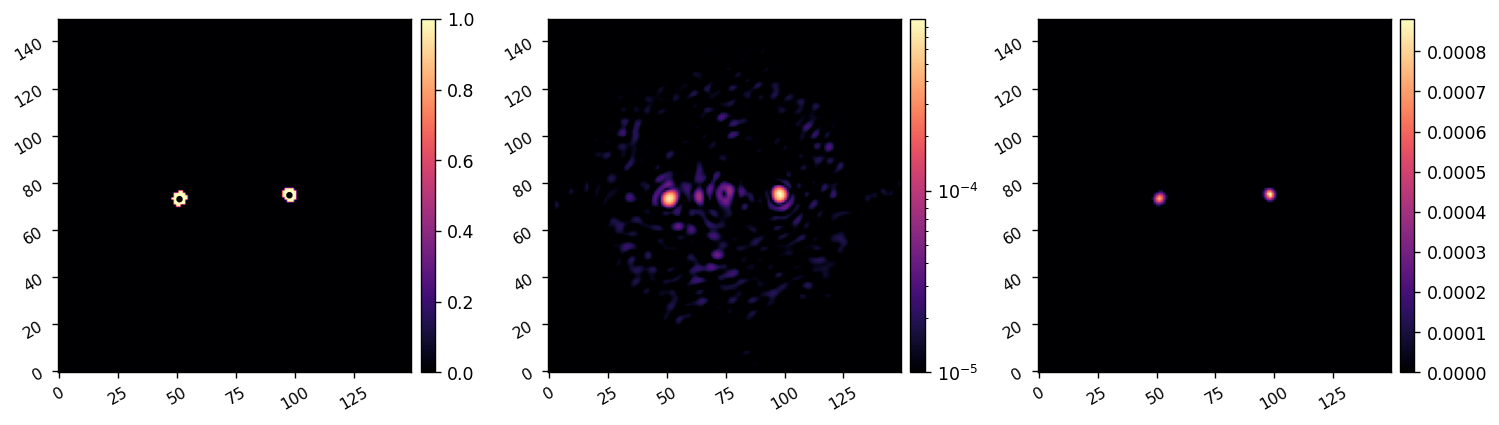

Pixelscale:
 0.30696790214767256


In [116]:
def measure_pixelscale(sin_im, cpa, 
                       dm_diam=10.2, dm_lyot_mag=9.4/9.4, lyot_diam=8.6, 
                       im_thresh=1e-4, r_thresh=20, 
                       verbose=True, plot=True,):
    npsf = sin_im.shape[0]
    y,x = (xp.indices((npsf, npsf)) - npsf//2)
    r = xp.sqrt(x**2 + y**2)
    sin_mask = (sin_im >im_thresh) * (r>r_thresh)
    imshow2(sin_mask, sin_mask*sin_im)

    centroids = []
    for i in [0,1]:
        arr = sin_im[:, i*npsf//2:(i+1)*npsf//2]
        mask = sin_mask[:, i*npsf//2:(i+1)*npsf//2]
        cent = np.flip(skimage.measure.centroid(ensure_np_array(mask*arr)))
        cent[0] += i*npsf//2
        centroids.append(cent)
        # print(cent)
        # imshow3(mask, arr, mask*arr, lognorm2=True,
        #         patches1=[Circle(cent, 1, fill=True, color='cyan')])
    centroids = np.array(centroids)
    if verbose: print('Centroids:\n', centroids)

    if plot: 
        patches = []
        for i in range(2):
            patches.append(Circle(centroids[i], 1, fill=True, color='black'))
        imshow3(sin_mask, sin_im, sin_mask*sin_im, lognorm2=True, vmin2=1e-5,
                patches1=patches)

    sep_pix = np.sqrt((centroids[1][0] - centroids[0][0])**2 + (centroids[1][1] - centroids[0][1])**2)
    pixelscale_lamD = (2*cpa) / sep_pix * lyot_diam/(dm_diam * dm_lyot_mag)
    if verbose: print('Pixelscale:\n', pixelscale_lamD)

    return pixelscale_lamD

pixelscale_lamD = measure_pixelscale(sin_im, cpa=8.5, im_thresh=1e-4, r_thresh=10)

In [124]:
tbi.psf_pixelscale_lamD = pixelscale_lamD

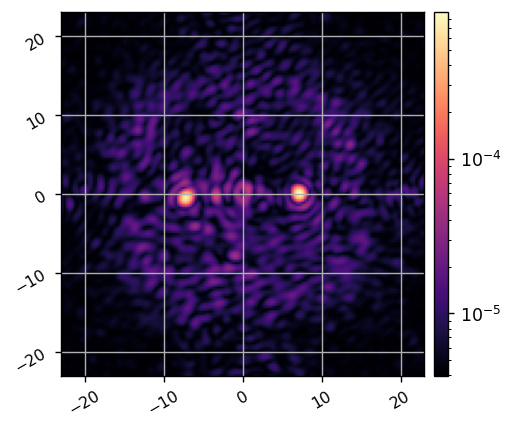

In [119]:
imshow1(sin_im, lognorm=True, pxscl=pixelscale_lamD, grid=True)

In [121]:
tbi.zero_dm()

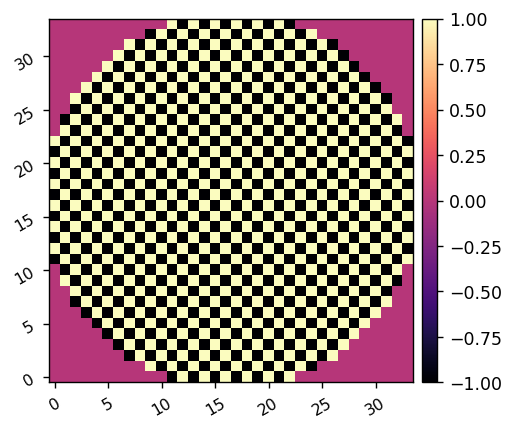

In [123]:
waffle_command = create_sin_command(x_cpa=17, y_cpa=17) * xp.array(tbi.dm_mask)
imshow1(waffle_command)

In [127]:
tbi.set_dm(10e-9 * waffle_command)

In [132]:
tbi.npsf = 150
waffle_im = tbi.snap()

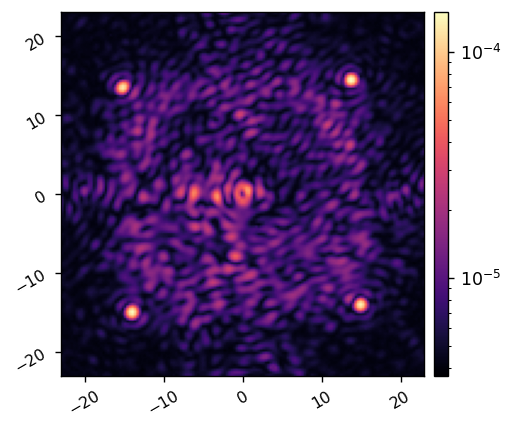

In [133]:
imshow1(waffle_im, lognorm=True, pxscl=tbi.psf_pixelscale_lamD)

Centroids:
 [[ 28.75737927  25.71702702]
 [ 24.98455157 118.47658552]
 [119.21811816 121.51408231]
 [123.0050286   28.86204377]
 [ 28.75737927  25.71702702]]


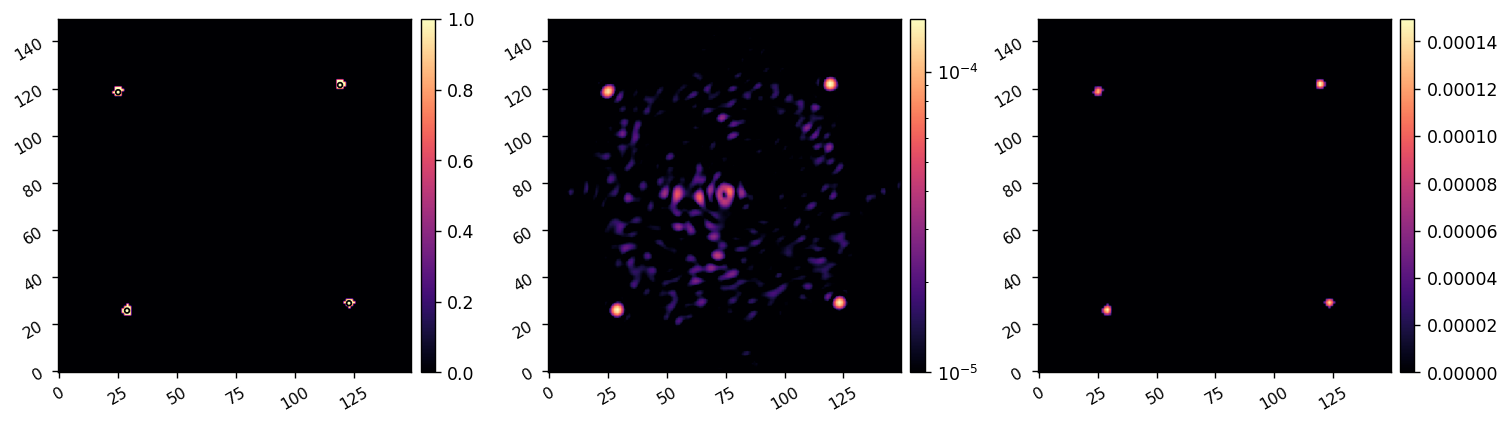

Angle:  87.89322955878923


In [139]:
angle = utils.measure_center_and_angle(waffle_im, tbi.psf_pixelscale_lamD, im_thresh=5e-5, r_thresh=15)

In [149]:
tbi.zero_dm()